In [ ]:

import numpy as np
import matplotlib.pyplot as plt
import os

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models,layers

In [ ]:
IMAGE_SIZE=256
BATCH_SIZE=32

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Importing Dataset

In [ ]:
df=tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/Colab Notebooks/PlantVillage",
    shuffle=True,
  image_size=(IMAGE_SIZE, IMAGE_SIZE), 
  batch_size=BATCH_SIZE
)
# df=os.listdir(r"New Plant Diseases Dataset(Augmented)\New Plant Diseases Dataset(Augmented)\train",image_size=(IMAGE_SIZE,IMAGE_SIZE),batch_size=(BATCH_SIZE,BATCH_SIZE))



Found 2152 files belonging to 3 classes.


In [ ]:
class_names=df.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [ ]:
len(df) # 568*32 images

68

In [ ]:
length=len(df)
length

68

In [ ]:
for image_batch,label_batch in df.take(1):
    print(image_batch.shape)

(32, 256, 256, 3)


Image Visuallisation

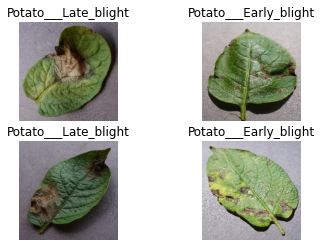

In [ ]:
for image_batch,label_batch in df.take(1):
     for i in range(4):
      ax=plt.subplot(2,2,i+1)
      plt.imshow(image_batch[i].numpy().astype(np.uint8))
      plt.title(class_names[label_batch[i]])
      plt.axis("off")

Spilliting Dataset

In [ ]:
#train_test
train_size=0.8
length*train_size

54.400000000000006

In [ ]:
train_ds=df.take(54)
len(train_ds)

54

In [ ]:
#validation
test_df=df.skip(54)
len(test_df)


14

In [ ]:
val_size=0.1
len(df)*0.1

6.800000000000001

In [ ]:
val_ds=test_df.take(56)
len(val_ds)

0

In [ ]:
test_ds=test_df.skip(56)
len(test_ds)

0

In [ ]:
len(val_ds)+len(test_ds)

0

In [ ]:
def train_test_val_split(df,train_split=0.8,test_split=0.1,val_split=0.1,shuffle=True,shuffle_size=10000):
    length=len(df)
    x_train_size=int(length*train_split)
    val_size=int(length*val_split)
    train_ds=df.take(x_train_size)
    val_ds=df.skip(x_train_size).take(val_size)
    test_ds=df.skip(x_train_size).skip(val_size)
    return train_ds,val_ds,test_ds 

In [ ]:
train_ds,test_ds,val_ds=train_test_val_split(df)

In [ ]:
len(train_ds)

54

In [ ]:
len(val_ds)

8

In [ ]:
len(test_ds)

6

In [ ]:
train_test_val_split(df,train_size,val_size)

(<TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>,
 <TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>,
 <SkipDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>)

In [ ]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

Building a Model

In [ ]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1./255),
])


In [ ]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])


In [ ]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)


In [ ]:
CHANNELS=3
input_shape=(BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
n_classes=3
model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu',
                  input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)


In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [ ]:

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)


In [ ]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=10,
)


Epoch 1/10
54/54 [==============================] - 369s 4s/step - loss: 0.8833 - accuracy: 0.5087 - val_loss: 0.7679 - val_accuracy: 0.6509
Epoch 2/10
54/54 [==============================] - 225s 4s/step - loss: 0.5207 - accuracy: 0.7853 - val_loss: 0.5761 - val_accuracy: 0.7241
Epoch 3/10
54/54 [==============================] - 201s 4s/step - loss: 0.2863 - accuracy: 0.8796 - val_loss: 0.2593 - val_accuracy: 0.9095
Epoch 4/10
54/54 [==============================] - 199s 4s/step - loss: 0.2109 - accuracy: 0.9196 - val_loss: 0.1493 - val_accuracy: 0.9526
Epoch 5/10
54/54 [==============================] - 202s 4s/step - loss: 0.1311 - accuracy: 0.9566 - val_loss: 0.1124 - val_accuracy: 0.9526
Epoch 6/10
54/54 [==============================] - 202s 4s/step - loss: 0.1740 - accuracy: 0.9381 - val_loss: 0.2048 - val_accuracy: 0.9095
Epoch 7/10
54/54 [==============================] - 202s 4s/step - loss: 0.1664 - accuracy: 0.9387 - val_loss: 0.1220 - val_accuracy: 0.9612
Epoch 8/10
54

In [ ]:
scores=model.evaluate(test_ds)

6/6 [==============================] - 12s 954ms/step - loss: 0.1028 - accuracy: 0.9740


In [ ]:
scores

[0.1028212308883667, 0.9739583134651184]

In [ ]:
accuracy=history.history['accuracy']
val_accuracy=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

Text(0.5, 1.0, 'Accuracy')

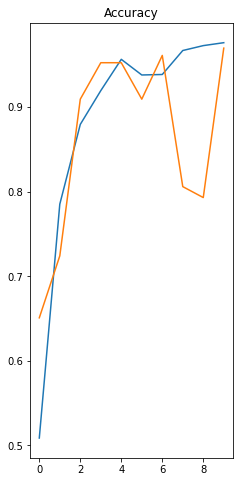

In [ ]:
EPOCHS=10
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),accuracy,label='Training_Accuracy')
plt.plot(range(EPOCHS),val_accuracy,label='validation_Accuracy')
plt.title('Accuracy')

Text(0.5, 1.0, 'Loss')

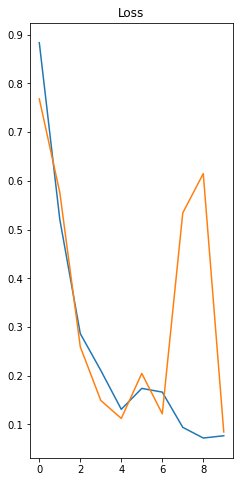

In [ ]:
EPOCHS=10
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),loss,label='Training_loss')
plt.plot(range(EPOCHS),val_loss,label='validation_loss')
plt.title('Loss')

**Prediction On Model**

Prediction
Actual Disease label Potato___healthy
[2.383374e-07 5.834437e-02 9.416554e-01]
predicted Disease label Potato___healthy
94.17 %


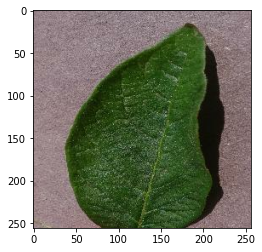

In [ ]:
for image_batch,label_batch in test_ds.take(1):
  image=(image_batch[0].numpy().astype('uint8'))
  label=label_batch[0].numpy()

  print("Prediction")
  plt.imshow(image)
  print("Actual Disease label",class_names[label])
  image_batch_pred=model.predict(image_batch)
  print((image_batch_pred[0]))
  pred=np.argmax(image_batch_pred[0])
  print("predicted Disease label", class_names[pred])
  confidence=round(100*(np.max( image_batch_pred[0])),2)
  print(confidence,"%")
